In this project, Generative Adversarial Networks are used to generate new images of faces. [Here is the code](https://github.com/Pradhyo/udacity-deep-learning-nanodegree/tree/master/face_generation) for this project which was a part of [Udacity's](https://www.udacity.com/) [Deep Learning Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101).

### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 35kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

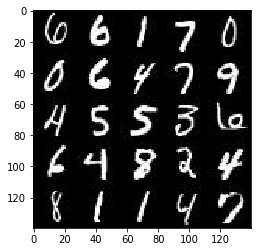

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

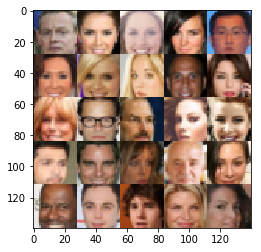

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    l_r = tf.placeholder(tf.float32, name='l_r')
    return input_real, input_z, l_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.12 # between 0.6 and 0.18
    keep_prob = 0.5
    
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    # Using xavier weight initalization on each conv2d layer - https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/
    
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        relu1 = tf.maximum(alpha * x1, x1)        
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        d2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        d3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.12 # between 0.6 and 0.18
    keep_prob = 0.5
    
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    # Generator bigger than discriminator
    # Make sure there are enough parameters to learn the concepts of the input images
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        # Working backwards, this is 7x7xanything
        x1 = tf.layers.dense(z, 7*7*1024)
        
        # Reshape it to start the convolutional stack     
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 7x7x1024 now

        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 28x28x256 now

        # Use strides=1 to preserve 28x28
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)  
        # 28x28x128 now        
        
        # Output layer
        # Use strides=1 to preserve 28x28
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)    
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # https://arxiv.org/abs/1606.03498
    # prevents discriminator from being too strong
    smooth = 0.2 
    
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake) * (1 - smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def plot_losses(d_loss_vec, g_loss_vec):
    print(d_loss_vec, g_loss_vec)
    Discriminator_loss, = pyplot.plot(d_loss_vec, color='b', label='Discriminator loss')
    Genereator_loss, = pyplot.plot(g_loss_vec, color='r', label='Generator loss')
    pyplot.legend(handles=[ Discriminator_loss, Genereator_loss])    
    

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, l_r = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_r, beta1)
    d_loss_vec = []
    g_loss_vec = []
    
    try:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch_i in range(epoch_count):
                for batch_images in get_batches(batch_size):
                    # TODO: Train Model
                    batch_images *= 2 # Scale from [-0.5, 0.5] to [-1, 1]
                    steps += 1

                    # Sample random noise for G
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))      

                    # Run optimizers
                    _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})

                    # Optimize twice for generator so discriminator loss does not go to 0
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_r: learning_rate})
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_r: learning_rate})

                    # Store losses every 10 steps for plotting
                    if steps % 10 == 0:
                        train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                        train_loss_g = g_loss.eval({input_z: batch_z})   
                        d_loss_vec.append(train_loss_d)
                        g_loss_vec.append(train_loss_g)
                    
                    # Display loss and generator output every 100 steps
                    if steps % 100 == 0:                        
                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))

                        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        plot_losses(d_loss_vec, g_loss_vec)
    
    except KeyboardInterrupt:
        plot_losses(d_loss_vec, g_loss_vec)
        raise

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7631... Generator Loss: 0.4857


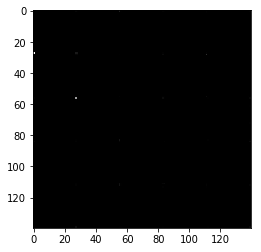

Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 1.0257


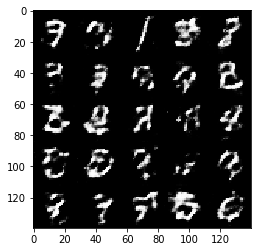

Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 1.0466


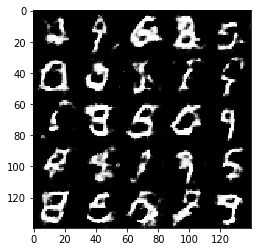

Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 1.2983


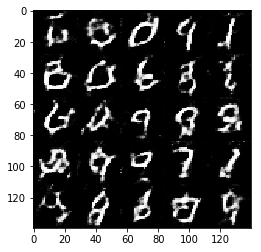

Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 1.1439


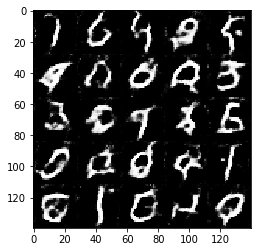

Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 1.0628


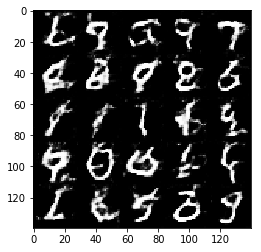

Epoch 1/2... Discriminator Loss: 1.3721... Generator Loss: 0.7614


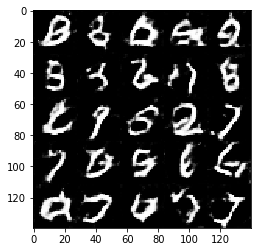

Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.7005


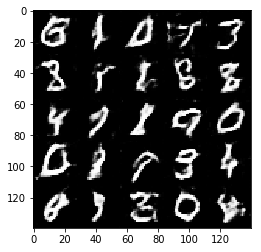

Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 1.0910


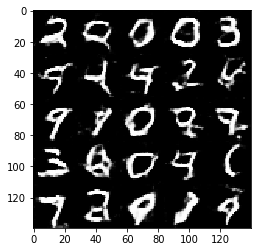

Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.7493


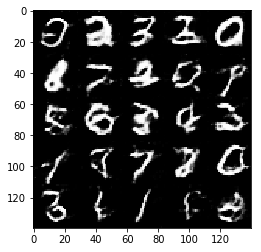

Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.8532


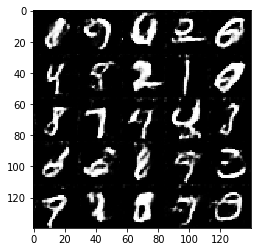

Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.7904


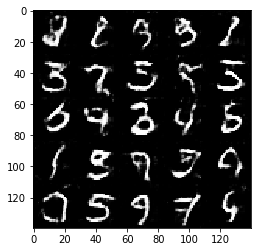

Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.9467


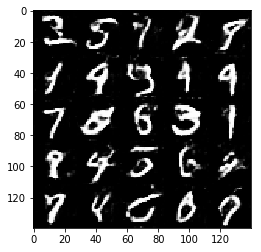

Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.8512


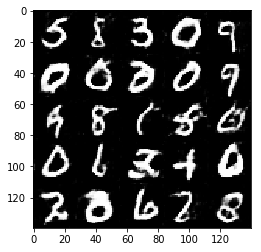

Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.8836


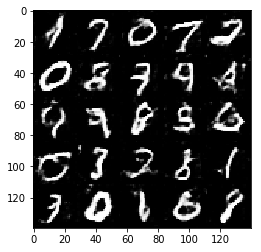

Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.7999


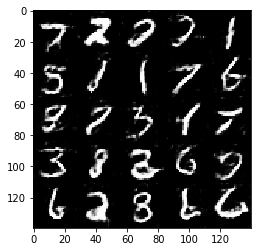

Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.9189


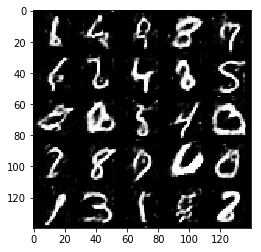

Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 1.1281


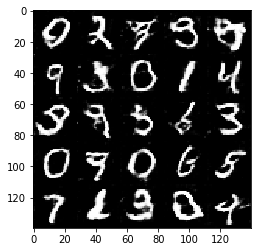

Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.7287


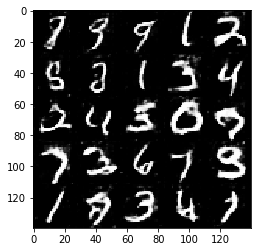

Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 1.0550


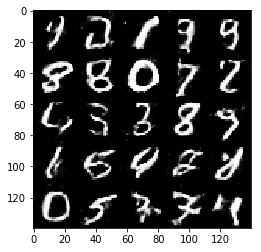

Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.6742


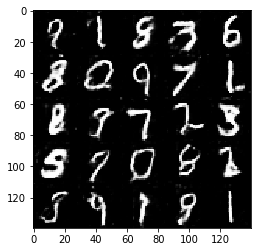

Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.7185


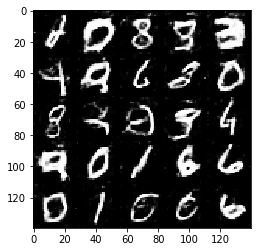

Epoch 2/2... Discriminator Loss: 1.5820... Generator Loss: 0.8377


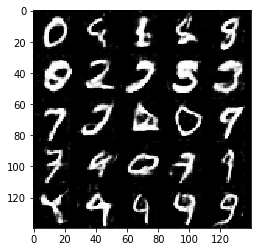

Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.9154


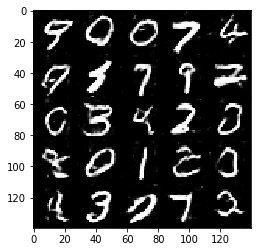

Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 1.0773


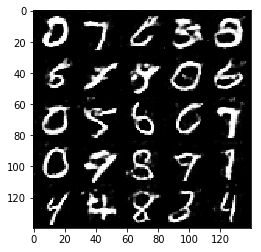

Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 1.0234


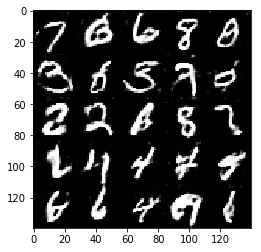

Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.6979


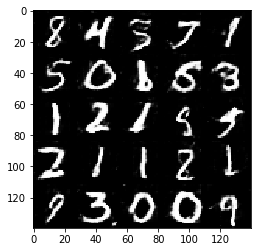

Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.8884


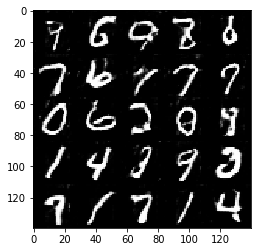

Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 1.1571


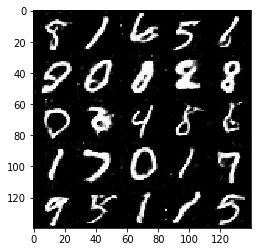

Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 1.0748


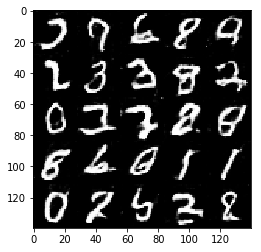

Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 1.1076


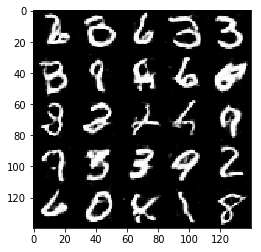

Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 1.5720


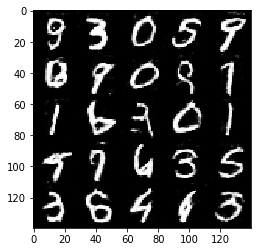

Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 1.1581


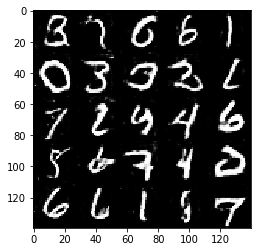

Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 1.0179


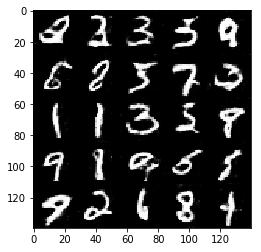

Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 1.1422


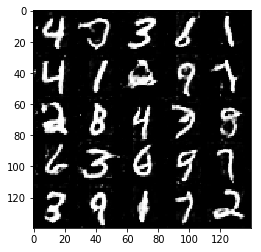

Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 1.2989


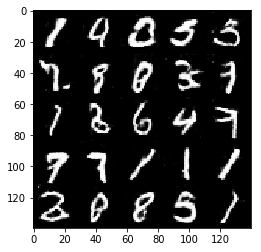

Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.7897


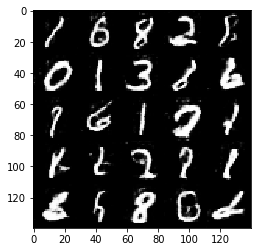

NameError: name 'plt' is not defined

In [12]:
# if batch size is too small use small learning rate as gradients will be more unstable
batch_size = 32 # start experimenting between 16 and 32
z_dim = 128 # 128 - 256
learning_rate = 0.0003 # between 0.0002 and 0.0008
beta1 = 0.4 # between 0.2 and 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

*Plotting failed above because of a typo but fixed it for below.*

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.8973


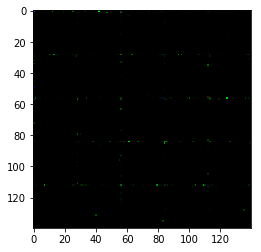

Epoch 1/1... Discriminator Loss: 1.6832... Generator Loss: 1.4495


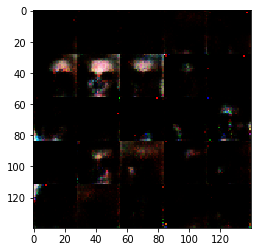

Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7879


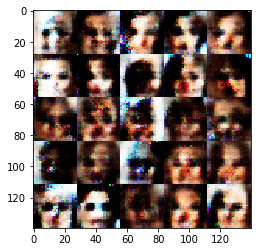

Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 0.6088


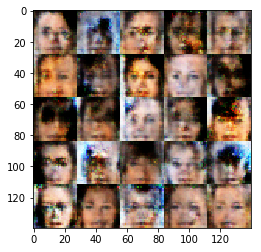

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7341


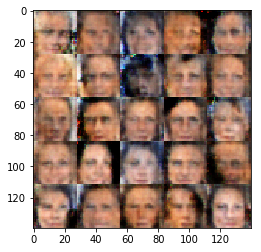

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.9456


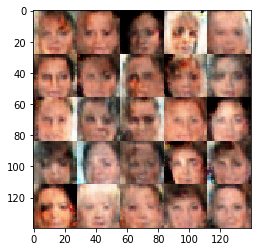

Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7972


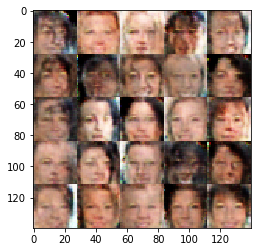

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8995


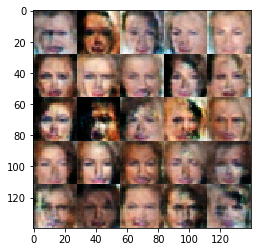

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7624


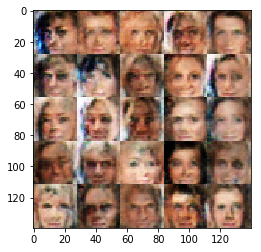

Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.7489


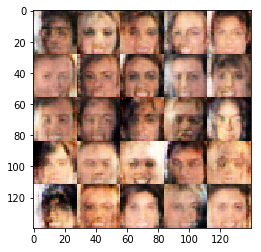

Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8543


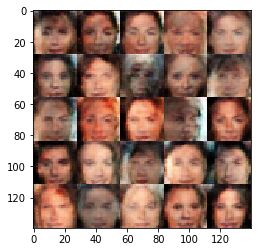

Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.8888


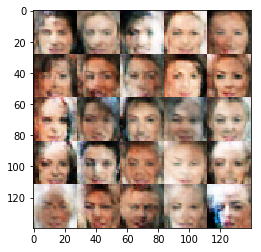

Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8978


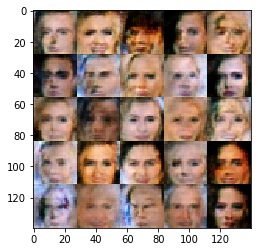

Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8631


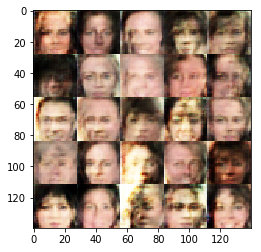

Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.7636


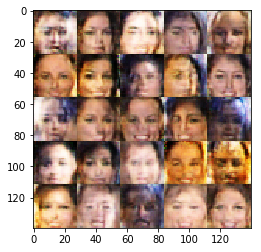

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.8877


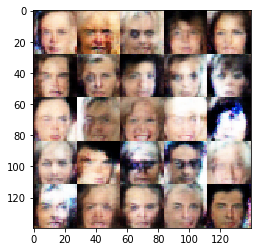

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8720


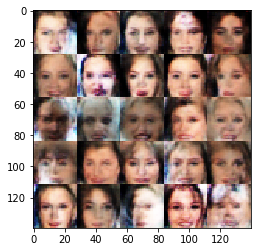

[0.68147719, 1.0819838, 1.7858406, 1.2155141, 0.89022237, 0.84738535, 0.92325556, 0.77138579, 1.3210111, 1.4313657, 1.0422797, 1.0290053, 1.0530705, 1.3202217, 1.3480206, 1.8708965, 1.4621553, 1.2714307, 1.684045, 1.6832254, 1.4807202, 1.7142226, 1.7021042, 1.2245331, 1.7188144, 1.316097, 1.5010058, 1.3194613, 1.5687752, 1.4654884, 1.4800744, 1.8908931, 1.3160625, 1.6250725, 1.3586822, 1.2754176, 1.5521997, 1.3508202, 1.501712, 1.6592243, 1.5546122, 1.4520644, 1.2715205, 1.5537705, 1.480042, 1.4518548, 1.6001701, 1.3779323, 1.4202495, 1.3956763, 1.5855815, 1.5098754, 1.5925955, 1.6071342, 1.3609899, 1.3971056, 1.4317162, 1.5298216, 1.4867867, 1.4305775, 1.4616724, 1.4394225, 1.2894374, 1.4362776, 1.4443917, 1.4505243, 1.3482745, 1.3224802, 1.3685384, 1.4629893, 1.3737476, 1.3450725, 1.4742806, 1.4334176, 1.4813404, 1.5029886, 1.451731, 1.4808697, 1.4941374, 1.3861592, 1.3457894, 1.5035008, 1.4697601, 1.4285893, 1.487663, 1.5893745, 1.4142377, 1.4513512, 1.2983847, 1.4573878, 1.4092219,

KeyboardInterrupt: 

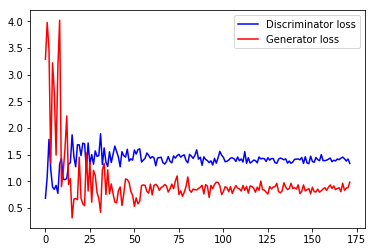

In [24]:
# if batch size is too small use small learning rate as gradients will be more unstable
batch_size = 32 # start experimenting between 16 and 32
z_dim = 128 # 128 - 256
learning_rate = 0.0003 # between 0.0002 and 0.0008
beta1 = 0.4 # between 0.2 and 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Results

Some of the images of digits generated were very realistic but the images of the faces are less so.    
The Generator loss is below the Discriminator loss as seen above which is a step in the right direction.